In [59]:
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
import numpy as np

%matplotlib inline

# up figure resolution
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 150

import warnings
warnings.filterwarnings('ignore')

import pyvista as pv
from pyvista import set_plot_theme
set_plot_theme('document')

from pyprojroot import here
import geopy.distance

In [60]:
ld_backup = pd.read_csv(f"http://data.insideairbnb.com/spain/catalonia/barcelona/2020-02-16/data/listings.csv.gz")

In [61]:
ld = ld_backup.copy()

# convert price dtype
ld['price'] = ld.price.str[1:].replace("$", '')
ld['price'] = ld.price.str.replace(',', '')
ld['price'] = ld.price.astype(float)

# log of price
ld['price_log'] = ld.price.apply(np.log)
ld['price_log'] = ld.price_log.replace([np.inf, -np.inf], np.nan)
ld['price_log'] = ld.price_log.fillna(value=0)


# calculcate deal index
ld['deal_index'] = ld.review_scores_rating / ld.price

# calculate distance from Plaza de Catalonia
def get_distance(apartment_coords):
    catalonia_square_coords = (41.386710, 2.169401)
    distance = geopy.distance.vincenty(catalonia_square_coords, apartment_coords).km
    return distance

ld['distance_from_catalonia_square'] = ld[['latitude', 'longitude']].apply(get_distance, raw=True, axis=1)

# dropna
ld = ld.dropna(subset=['deal_index'])

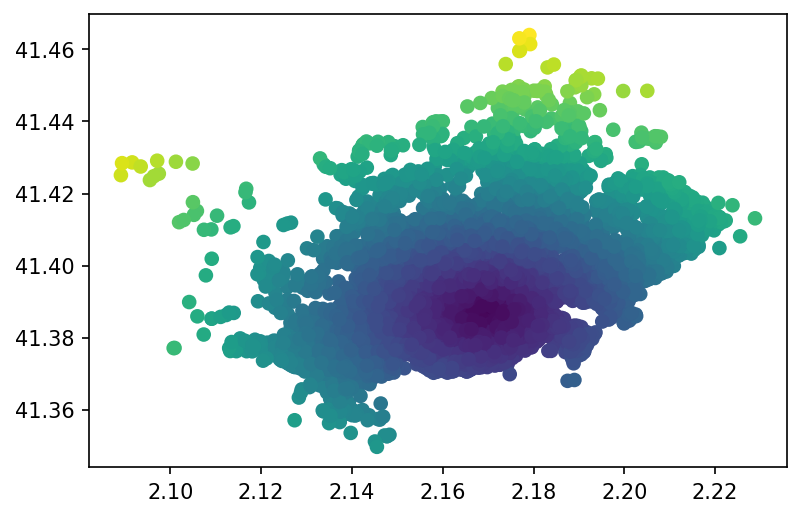

In [62]:
plt.scatter(ld.longitude, ld.latitude, c=ld.distance_from_catalonia_square);

# Linear model

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

lr = LinearRegression()

data = ld.copy()

# filters
data = data[data.price < 1500]
data = data[data.property_type == 'Apartment']

# select columns to model
data = data[['bathrooms', 
             'bedrooms', 
             'price', 
             'accommodates', 
             'neighbourhood_group_cleansed', 
             'beds', 
             'distance_from_catalonia_square']]
data = data.dropna()

#dummify
categorical_columns = ['neighbourhood_group_cleansed']
dummies = pd.get_dummies(data[categorical_columns])
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns=categorical_columns)


X = data.drop(columns=['price'])
y = data.price

y_pred = cross_val_predict(lr, X, y, cv=10)

mae = np.abs(y_pred - y)

mae.describe()

count    13361.000000
mean        42.739581
std         71.027224
min          0.000000
25%         10.593750
50%         23.890625
75%         48.500000
max       1061.109375
Name: price, dtype: float64

Text(0.5, 0, 'measured')

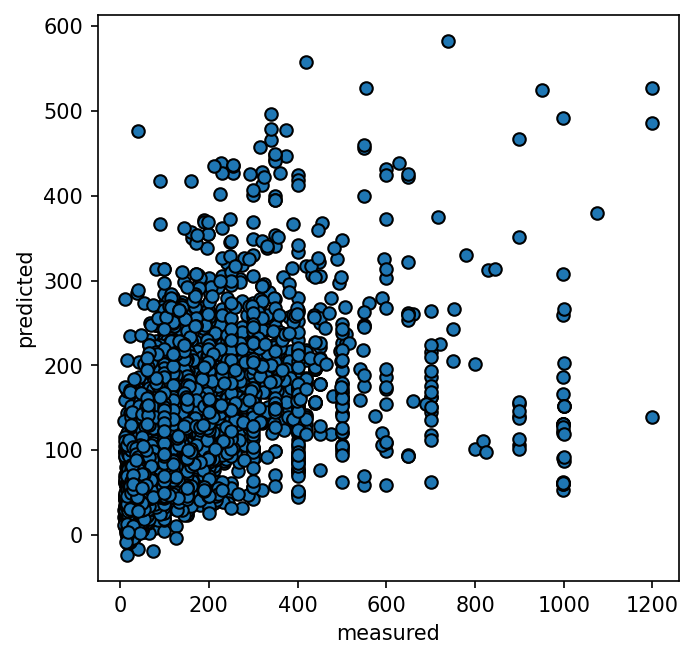

In [64]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
ax.set_ylabel('predicted')
ax.set_xlabel('measured')

Text(0.5, 0, 'measurement')

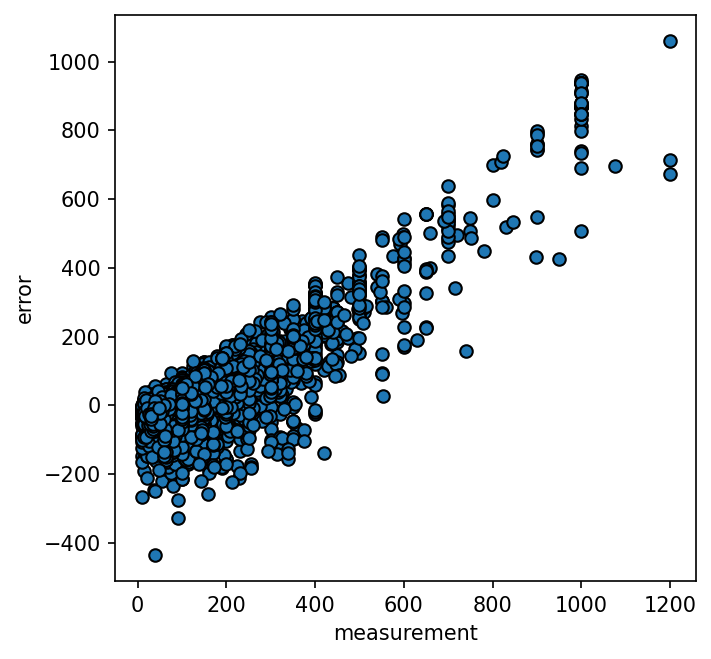

In [65]:
error = y - y_pred
plt.figure(figsize=(5,5))
plt.scatter(y, error, edgecolors=(0, 0, 0));
plt.ylabel('error')
plt.xlabel('measurement')

In [66]:
import seaborn as sns

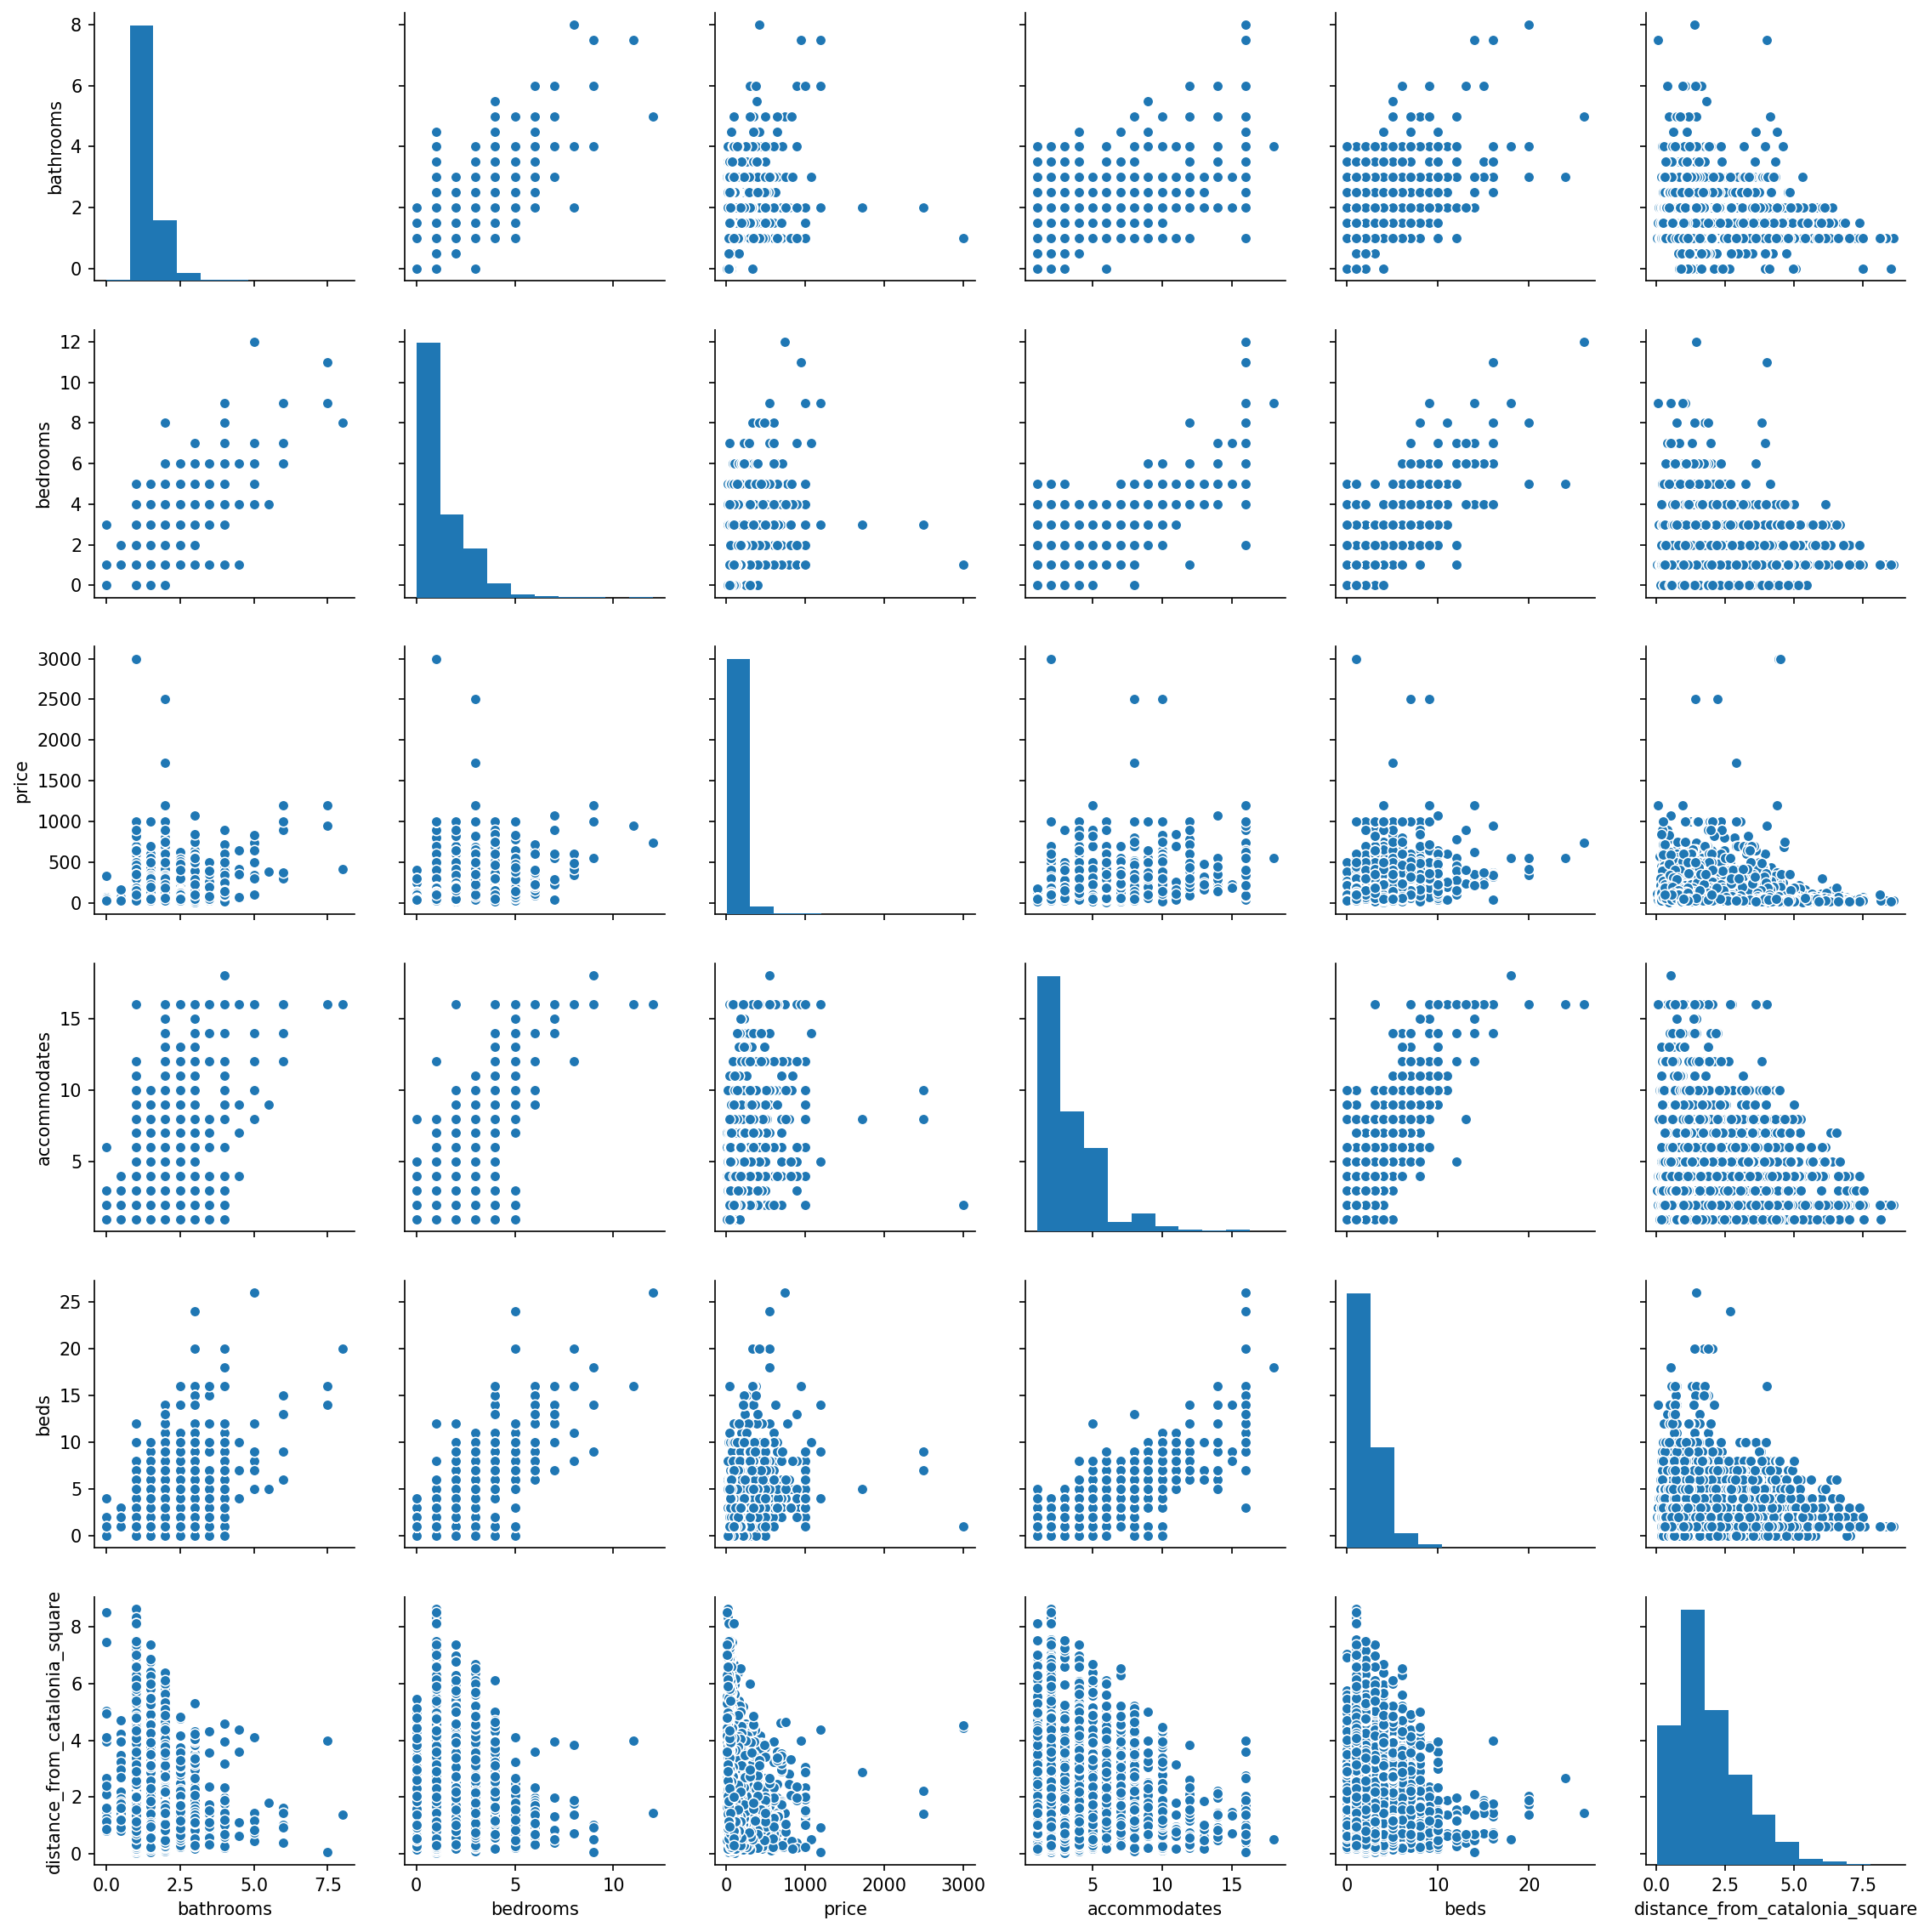

In [67]:
data = ld.copy()

# filters
data = data[data.price < 4000]
data = data[data.property_type == 'Apartment']

# select columns to model
data = data[['bathrooms', 
             'bedrooms', 
             'price', 
             'accommodates', 
             'beds', 
             'distance_from_catalonia_square']]

sns.pairplot(data)

In [68]:
data.corr()

,bathrooms,bedrooms,price,accommodates,beds,distance_from_catalonia_square
bathrooms,1.000000,0.516950,0.329680,0.487536,0.483967,-0.109312
bedrooms,0.516950,1.000000,0.472572,0.838297,0.829192,-0.047195
price,0.329680,0.472572,1.000000,0.523058,0.483133,-0.094250
accommodates,0.487536,0.838297,0.523058,1.000000,0.874880,-0.099212
beds,0.483967,0.829192,0.483133,0.874880,1.000000,-0.059919
distance_from_catalonia_square,-0.109312,-0.047195,-0.094250,-0.099212,-0.059919,1.000000


## Map widget